# Unity ML-Agents Toolkit
## Environment Basics
This notebook contains a walkthrough of the basic functions of the Python API for the Unity ML-Agents toolkit. For instructions on building a Unity environment, see [here](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Getting-Started-with-Balance-Ball.md).

### 1. Set environment parameters

Be sure to set `env_name` to the name of the Unity environment file you want to launch. Ensure that the environment build is in the `python/` directory.

In [1]:
env_name = "./Banana_Linux/Banana.x86_64"
train_mode = True  # Whether to run the environment in training or inference mode

### 2. Load dependencies

The following loads the necessary dependencies and checks the Python version (at runtime). ML-Agents Toolkit (v0.3 onwards) requires Python 3.

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import sys

import random
from collections import namedtuple, deque

from unityagents import UnityEnvironment

%matplotlib inline

print("Python version:")
print(sys.version)

# check Python version
if (sys.version_info[0] < 3):
    raise Exception("ERROR: ML-Agents Toolkit (v0.3 onwards) requires Python 3")

Python version:
3.6.8 (default, Jan 14 2019, 11:02:34) 
[GCC 8.0.1 20180414 (experimental) [trunk revision 259383]]


### 3. Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


### 4. Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

In [4]:
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]

# Examine the state space for the default brain
print("Agent state looks like: \n{}".format(env_info.vector_observations[0]))

# Examine the observation space for the default brain
for observation in env_info.visual_observations:
    print("Agent observations look like:", observation.shape)
    if observation.shape[3] == 3:
        plt.imshow(observation[0,:,:,:])
    else:
        plt.imshow(observation[0,:,:,0])

Agent state looks like: 
[1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]


### 5. Take random actions in the environment
Once we restart an environment, we can step the environment forward and provide actions to all of the agents within the environment. Here we simply choose random actions based on the `action_space_type` of the default brain. 

Once this cell is executed, 10 messages will be printed that detail how much reward will be accumulated for the next 10 episodes. The Unity environment will then pause, waiting for further signals telling it what to do next. Thus, not seeing any animation is expected when running this cell.

In [5]:
for episode in range(1):
    env_info = env.reset(train_mode=train_mode)[default_brain]
    done = False
    episode_rewards = 0
    while not done:
        if brain.vector_action_space_type == 'continuous':
            env_info = env.step(np.random.randn(len(env_info.agents), 
                                                brain.vector_action_space_size))[default_brain]
        else:
            env_info = env.step(np.random.randint(0, brain.vector_action_space_size, 
                                                  size=(len(env_info.agents))))[default_brain]
        episode_rewards += env_info.rewards[0]
        done = env_info.local_done[0]
    print("Total reward this episode: {}".format(episode_rewards))

Total reward this episode: 0.0


### 6. Declare our model for the Q Network
We'll use a a simple neural network with linear functions and then the result will be a RELU

In [6]:
class QNetwork(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, neurons = 50, seed = None):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            
        NOTE: skeleton provided by Udacity
        """
        super(QNetwork, self).__init__()
        if seed == 0 or seed:
            self.seed = torch.manual_seed(seed)
        else:
            print('Seed is set to default None.')
        self.l_in = nn.Linear(state_size,neurons)
        self.hidden = nn.Linear(neurons, neurons)
        self.l_out = nn.Linear(neurons, action_size)
        self.activ = nn.ReLU()

    def forward(self, state):
        """Build a network that maps state -> action values."""
        state = self.l_in(state)
        state = self.activ(state)
        state = self.hidden(state)
        state = self.activ(state)
        state = self.l_out(state)
        return state

### 7. Our agent
Will be responsible of learning from the previous actions (with the ReplayBuffer) and deciding with action to take based on the current state

In [7]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate 
UPDATE_EVERY = 4        # how often to update the network

#check if gpu/cuda is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
WEIGHTS_FILE = "Bananas-weights.pth"

In [8]:

class Agent:
    def __init__(self, state_size, action_size, neurons = 50, seed=None):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.qnetwork_local = QNetwork(state_size, action_size, neurons, seed).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size, neurons, seed).to(device)
        self.qnetwork_target.eval()
        self.optimizer = optim.Adam(self.qnetwork_local.parameters(), lr=LR)
        self.loss = torch.nn.MSELoss()
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed)
        self.t_step = 0
    def update(self, state, action, reward, next_state, done):
        # Save experience in replay memory
        self.memory.add(state, action, reward, next_state, done)
        
        # Learn every UPDATE_EVERY time steps.
        self.t_step = (self.t_step + 1) % UPDATE_EVERY
        if self.t_step == 0:
            # If enough samples are available in memory, get random subset and learn
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences, GAMMA)
    def act(self, state, eps=0.):
        """
        Returns an action given the state.

            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection,
                            if eps is too high, the chances the policy choses an option a random choice are higher, useful for exploration
                            if eps is too low, will use the neural network to get the actions
        """
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork_local.eval()
        with torch.no_grad():
            action_values = self.qnetwork_local(state)
        self.qnetwork_local.train()

        # Epsilon-greedy action selection
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))
    def learn(self, experiences, gamma):
        """
        Update value parameters using given batch of experience tuples.

            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        ## TODO: compute and minimize the loss
        "*** YOUR CODE HERE ***"
        with torch.no_grad():
            maxQ_target = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        targets = rewards + gamma*maxQ_target*(1-dones)
        y = self.qnetwork_local(states)
        y = y.gather(1,actions)
        loss = self.loss(y,targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.soft_update(self.qnetwork_local, self.qnetwork_target, TAU)                     
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model (PyTorch model): weights will be copied from
            target_model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


### 8. Declare our replay buffer
Will be useful for the agent to take the N previous experiences to learn from it

In [9]:

class ReplayBuffer:
    """Fixed-size buffer to store experience tuples.
    NOTE: provided by Udacity"""

    def __init__(self, action_size, buffer_size, batch_size, seed):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
    
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

### 9. Do the training
We will declare our training function with parameters so we can test how these affect to the performance of the network

In [10]:
def train_dqn(env, agent, 
              solved_cond = 14.0, n_episodes=2000, max_t=1000,
              eps_start=1.0, eps_end=0.01, eps_decay=0.995  ):
    """Train a Deep Q-Learning agent in the given environment.
    Args
    ====
        env (object): Unity environment; the function uses the default brain
        agent (object): RL agent 
    Params
    ======
        solved_cond (float): averaged score condition to consider the environment solved; average is over 100 episodes
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """
    
    brain_name = env.brain_names[0]    # get the default brain
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = int(agent.act(state, eps))
            env_info = env.step(action)[brain_name]        # send the action to the environment
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # check if the episode is done
            agent.update(state, action, reward, next_state, done) # update agent Q-values and replay buffer
            state = next_state
            score += reward
            if done:
                break 
        scores_window.append(score)       # save most recent score
        scores.append(score)              
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        # Check if the averaged score is larger/equal than the condition for solving the environment
        if np.mean(scores_window)>=solved_cond: 
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), WEIGHTS_FILE)
            break
    return scores



In [11]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)
state_size = len(env_info.vector_observations[0])
print('Number of states:', state_size)


Number of actions: 4
Number of states: 37


In [16]:
LOAD_MODEL = False

In [17]:
#Define agent
agent = Agent(state_size=state_size, action_size=action_size, neurons=50, seed=0)

In [18]:
if LOAD_MODEL:
    agent.qnetwork_local.load_state_dict(torch.load(WEIGHTS_FILE))

Episode 100	Average Score: 1.13
Episode 200	Average Score: 3.56
Episode 300	Average Score: 7.34
Episode 400	Average Score: 10.74
Episode 500	Average Score: 13.76
Episode 514	Average Score: 14.02
Environment solved in 414 episodes!	Average Score: 14.02


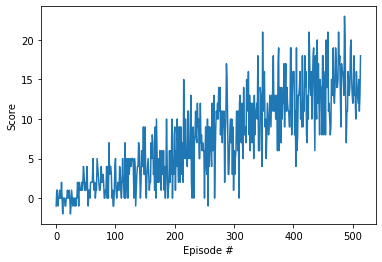

In [19]:

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# Train agent 
scores = train_dqn(env, agent)

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [15]:
env_info = env.reset(train_mode=False)[brain_name]
env_info.vector_observations

array([[0.        , 0.        , 1.        , 0.        , 0.16101955,
        1.        , 0.        , 0.        , 0.        , 0.04571758,
        1.        , 0.        , 0.        , 0.        , 0.2937662 ,
        0.        , 0.        , 1.        , 0.        , 0.14386636,
        0.        , 0.        , 1.        , 0.        , 0.16776823,
        1.        , 0.        , 0.        , 0.        , 0.04420976,
        1.        , 0.        , 0.        , 0.        , 0.05423063,
        0.        , 0.        ]])

In [16]:
#Show agent sampling correct bananas
print("\n Testing agent's performance...")
env_info = env.reset(train_mode=False)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
score = 0                                          # initialize the score
eps = 0.01
while True:
    action = int(agent.act(state, eps))  # select an action
    env_info = env.step(action)[brain_name]        # send the action to the environment
    next_state = env_info.vector_observations[0]   # get the next state
    reward = env_info.rewards[0]                   # get the reward
    done = env_info.local_done[0]                  # see if episode has finished
    score += reward                                # update the score
    state = next_state                             # roll over the state to next time step
    #time.sleep(0.1)
    if done:                                       # exit loop if episode finished
        print('Done!')
        print("Score: {}".format(score))
        break



 Testing agent's performance...
Done!
Score: 16.0


### Close the environment when finished
When we are finished using an environment, we can close it with the function below.

In [27]:
env.close()

UnityEnvironmentException: No Unity environment is loaded.